# Proyecto IMT3810

##### Nombre: Francisca Muñoz

### Instalación

Para utilizar este notebook correctamente, se debe instalar la librería $\texttt{bempp-cl}$, para esto se puede correr el saiguiente comando en la consola:

$\texttt{python setup.py install}$

Para otro tipo de instalaciones, por ejemplo en Docker, se puede acceder a la siguiente página:  [bempp.com/installation.html]( bempp.com/installation.html)

Otras librerías utilizadas fueron Numpy 

## Matrices Jerárquicas

Para el desarrollo de este Notebook trabajaremos con el ejemplo de Single Layer Potential para un problema de Laplace. Por esta razón, primero definiremos el problema utilizando Bempp.

In [1]:
import bempp.api
import numpy as np
import matplotlib.pyplot as plt

Realizamos también la importación de las funciones definidas para el proyecto

In [2]:
import functions

Creamos la geometría, las funciones de base y los potenciales a utilizar.

In [3]:
grid = bempp.api.shapes.sphere(h=0.1)

dp0_space = bempp.api.function_space(grid, "DP", 0)
p1_space = bempp.api.function_space(grid, "P", 1)

A continuación crearemos varios operadores para poder compararlos cualitativamente.

In [4]:
slp = bempp.api.operators.boundary.laplace.single_layer(
    dp0_space, p1_space, dp0_space)
matrix = slp.weak_form().A.copy()

A continuación, vamos a graficar los operadores, para tener una noción gráfica cualitativa de la densidad de dichas matrices.

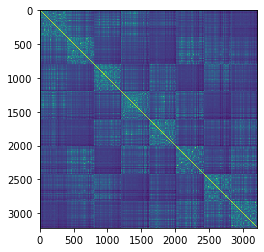

In [5]:
fig, ax = plt.subplots()
cax = ax.imshow(
    np.log(slp.weak_form().A), 
    cmap='viridis', 
    interpolation='nearest')
plt.show()


# Adaptive Cross Approximation

In [6]:
slp = bempp.api.operators.boundary.laplace.single_layer(
    dp0_space, p1_space, dp0_space)
matrix = slp.weak_form().A.copy()

n = np.shape(matrix)[0]
row, col =  functions.aca(matrix[n//2:,:n//2], 1e-8, n)

In [7]:
diff = np.linalg.norm((row.T@col) - (slp.weak_form().A)[n//2:,:n//2])
norm = np.linalg.norm((slp.weak_form().A)[n//2:,:n//2])
print("El error de la aproximación es:", diff/norm)

El error de la aproximación es: 0.0001431624718969907


También podemos ver graficamente el resultado de la matriz real y de la aproximación a continuación:

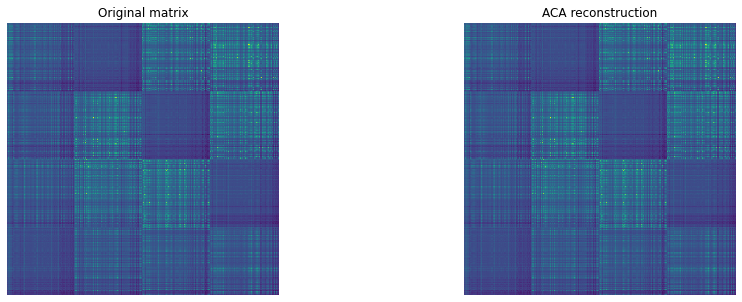

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(np.log((slp.weak_form().A)[n//2:,:n//2]), cmap='viridis', interpolation='nearest') 
axs[0].axis('off')  # Desactivar ejes
axs[0].set_title('Original matrix')

axs[1].imshow(np.log(row.T@col), cmap='viridis', interpolation='nearest')
axs[1].axis('off')
axs[1].set_title('ACA reconstruction')

plt.show()


Vemos que para aproximar la submatriz superior dereecha del single layer potential para el problema de Laplace, utilizando ACA, se optiene un error de $0.00014$. Ahora veremos como se comporta este error en función de la dimensión de la matriz.

In [9]:
#Realizaremos una lista de matrices de diferente dimensión para el 
#análisis de error

matrices = []
for i in range(1,10):
    grid = bempp.api.shapes.sphere(h=i/10)
    dp0_space = bempp.api.function_space(grid, "DP", 0)
    p1_space = bempp.api.function_space(grid, "P", 1)
    matrix = bempp.api.operators.boundary.laplace.single_layer(
       dp0_space, p1_space, dp0_space).weak_form().A
    matrices.append(matrix)

In [10]:
errores2 = np.zeros(10)
errores_inf = np.zeros(10)
x = np.zeros(10)
for i in range(9):
    matrix = matrices[i].copy()
    n = np.shape(matrix)[0]
    x[i] = n//2
    row, col =  functions.aca(matrix[n//2:,:n//2], 1e-8, n)
    norma2 = np.linalg.norm((matrices[i])[n//2:,:n//2])
    norma_inf = np.linalg.norm((matrices[i])[n//2:,:n//2], ord = np.inf)
    errores2[i] = np.linalg.norm((row.T@col) - (matrices[i])[n//2:,:n//2])/norma2    
    errores_inf[i] = np.linalg.norm((row.T@col) - (matrices[i])[n//2:,:n//2], ord = np.inf)/norma_inf

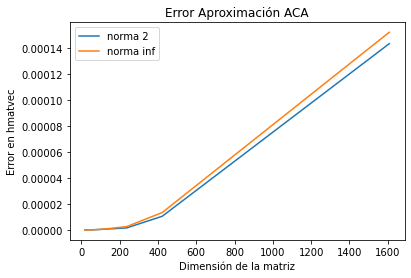

In [11]:
plt.plot(x[:-1], errores2[:-1], label = 'norma 2')
plt.plot(x[:-1], errores_inf[:-1], label = 'norma inf')
plt.title("Error Aproximación ACA")
plt.xlabel('Dimensión de la matriz')
plt.ylabel('Error en hmatvec')
plt.legend()

# Compresión para single Layer potential Laplace

Para la compresión de la Matriz, se realizó la siguiente función que permite comprimir en base al criterio de admisibilidad débil. Así, se realiza un árbol de expansión y se guardará en una lista ordenada por ramas del árbol, cada matriz ya sea en formato de ACA o densa para las matrices diagonales.

In [12]:
matrix = bempp.api.operators.boundary.laplace.single_layer(
    dp0_space, p1_space, dp0_space).weak_form().A

In [13]:
def hmat_com(matrix, iter_count, tolerance, sub_matrices):
    '''
    Compresión de la matriz en formato de árbol binario.
    
    Input
    matrix: matrix
    iter_count: máximo número de iteraciones
    sub_matrices: lista para almacenar la compresión
    
    Output
    sub_matrices: lista con las submatrices en orden de las ramas del árbol de expansión
    '''
    if np.shape(matrix)[0] < iter_count:
        return sub_matrices
    else:
        n_row, n_col = np.shape(matrix)
        a1, b1, _, _, _ = functions.aca(matrix[:n_row//2, n_col//2:], tolerance, 1)
        a2, b2, _, _, _ = functions.aca(matrix[n_row//2:, :n_col//2], tolerance, 1)
        sub_matrices.append([[a1, b1], [a2, b2]])
        hmat_com(matrix[:n_row//2, :n_col//2], iter_count, tolerance, sub_matrices)
        hmat_com(matrix[n_row//2:, n_col//2:], iter_count, tolerance, sub_matrices)

# Matvec

A continuación se presentan los resultados de error obtenidos con la función de operación matrix por vector para matrices jerárquicas.

In [14]:
#Utilizaremos el potencial de single layer para Laplace
grid = bempp.api.shapes.sphere(h=0.1)

dp0_space = bempp.api.function_space(grid, "DP", 0)
p1_space = bempp.api.function_space(grid, "P", 1)

slp = bempp.api.operators.boundary.laplace.single_layer(
    dp0_space, p1_space, dp0_space).weak_form().A

matrix = slp.copy()
vector = np.ones(np.shape(matrix)[0])

print('Dimensión de la matriz:', np.shape(matrix))


Dimensión de la matriz: (3216, 3216)


Testearemos con la matriz anterior de dimesión $3216 \times 3216$

In [15]:
result = functions.hmatvec(slp,vector, len(vector)/8)
print('Obtenemos un error de:' , np.linalg.norm(result - matrix@vector)/np.linalg.norm(matrix@vector))

Obtenemos un error de: 1.988520965214516e-05


Obtenemos un error de $$, ahora utilizando la lista de matrices anterior, veremos como varía el error de acuerdo a la dimensión de la matriz.

In [16]:
errores_matvec2 = np.zeros(10)
errores_matvec_inf = np.zeros(10)
x = np.zeros(10)
for i in range(9):
    matrix = matrices[i].copy()
    n = np.shape(matrix)[0]
    vector = np.ones(n)
    result =  functions.hmatvec(matrix, vector, n/8)
    x[i] = n
    norma2 = np.linalg.norm((matrices[i]@vector))
    norma_inf = np.linalg.norm((matrices[i]@vector), ord = np.inf)
    errores_matvec2[i] = np.linalg.norm(result - (matrices[i]@vector))/norma2
    errores_matvec_inf[i] = np.linalg.norm(result - (matrices[i]@vector), ord = np.inf)/norma_inf

In [17]:
errores_matvec2 = np.zeros(10)
errores_matvec_inf = np.zeros(10)
x = np.zeros(10)

for i in range(9):
    matrix = matrices[i].copy()
    n = np.shape(matrix)[0]
    vector = np.ones(n)
    result = functions.hmatvec(matrix, vector, n/8)
    x[i] = n
    norma2 = np.linalg.norm(matrices[i] @ vector)
    norma_inf = np.linalg.norm(matrices[i] @ vector, ord=np.inf)
    errores_matvec2[i] = np.linalg.norm(result - (matrices[i] @ vector)) / norma2
    errores_matvec_inf[i] = np.linalg.norm(result - (matrices[i] @ vector), ord=np.inf) / norma_inf



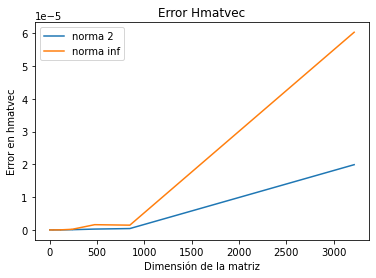

In [18]:
plt.plot(x, errores_matvec2, label = 'norma 2')
plt.plot(x, errores_matvec_inf, label = 'norma inf')
plt.title("Error Hmatvec")
plt.xlabel('Dimensión de la matriz')
plt.ylabel('Error en hmatvec')
plt.legend()

Anteriormente vemos que efectivamente el error aumenta con el aumento de la dimensión de la matriz. Sin embargo sigue siendo pequeño y en caso de necesitar un error menor aun se puede disminuir la tolerancia del algoritmo.